**Code to be implemented in order to perform multiple trajectories analysis**

In [ ]:
import numpy as np
from numpy import savetxt
from numpy import genfromtxt
import sys
import random
import matplotlib.pyplot as plt 
import csv
from scipy.optimize import curve_fit

**Functions**

In [14]:
def Mem_kernel(Cvv, dt):
  ##Function which return:
  #### g = Memory Kernel,
  #### G = integration of memory kernel
    nsamples = len(Cvv)-1

    G = np.zeros(nsamples)
    g = np.zeros(nsamples)
    
    G[0] = 2.*(Cvv[0]-Cvv[1])/(Cvv[0]+Cvv[1])
    for ii in range(1,nsamples):
        G[ii] = 2.*(Cvv[0]-Cvv[ii+1])/(Cvv[0] + Cvv[1])
        s = 0
        for jj in range(0,ii): 
          s = s + G[ii-(jj+1)]*(Cvv[jj+2] + Cvv[jj+1])/(Cvv[0] + Cvv[1])
        G[ii] = G[ii] - s

    # normalize
    G = G/dt
    
  # differentiate
    g[0] = 2*G[0]/dt
    g[1:] = np.diff(G)/dt;

    return G, g

In [15]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
  

In [16]:
def Velocities(x, dt):
    N = len(x)-1
    v = np.zeros(N)
    for k in range(N):
        v[k]=(x[k+1]-x[k])/dt
    return v

In [17]:
def calcCorrelationFunction(v, dt, nP, nLags):
  #abbreviate the square
    inv_sq_np = 1./np.sqrt(nP)

  ##Computation vacf
    vacf = np.fft.ifft(np.abs(np.fft.fft(v))**2)/len(v)
    vacf = np.real(vacf[0:len(vacf)//4])
  #normalize
    vacf = vacf/vacf[0]
    vacf = vacf[0:nLags + 1]
  #reserve memory
    uCorrFunc = np.zeros(nLags + 1)

  #get the error bar
    for iL in range(1,nLags + 1):

        if 1 == iL:

            uCorrFunc[iL] = 1/np.sqrt(nP)
            continue
    
        if iL > 1:

            tSum = 0.
      
            for iS in range(1,iL):
            
                tSum = tSum + (vacf[iS])**2.

            uCorrFunc[iL] = inv_sq_np * np.sqrt(1. + 2.*tSum)

            continue

    return vacf, uCorrFunc

In [18]:
def fit_VACF(x, v, a, b, c):
    return (v * np.exp(-a * x)*np.cos(b*x+c))

**Getting trajectories**

In [19]:
traj = genfromtxt('26012021_Image7_29um.csv', delimiter=',', encoding='utf-8-sig')

In [20]:
X = traj[:,0]
Y = traj[:,1]

**Defying my analysis class**

In [21]:
class Trajectory_Analysis: 
    
    def __init__(self,X, Y, nP, dT, w):
        
        # initialize memory
        self.vX = np.zeros(nP-1)
        self.vY = np.zeros(nP-1)
        # save parameters
        self.dT = dT
        self.X = X
        self.Y = Y
        self.w = w
        self.nP = nP
        
  
        self.__Smoothing()
        self.__ComputeVelocities()

    def __Smoothing(self):
        self.X = moving_average(self.X, self.w)
        self.Y = moving_average(self.Y, self.w)

    def __ComputeVelocities(self):
        self.vX = Velocities(self.X, self.dT)
        self.vY = Velocities(self.Y, self.dT)
  
    def getCorrFunction(self,nLags): 
    
        # initialize memory
        self.corr_vX = np.zeros(nLags + 1)
        self.corr_vY = np.zeros(nLags + 1)
            
        self.u_corr_vX = np.zeros(nLags + 1)
        self.u_corr_vY = np.zeros(nLags + 1)
            
        # calculate the correlations for components
        self.corr_vX,self.u_corr_vX = calcCorrelationFunction(self.vX, self.dT, self.nP, nLags)
        self.corr_vY,self.u_corr_vY = calcCorrelationFunction(self.vY,self.dT, self.nP, nLags)
            
        # calculate the velocity correlations
        self.corr_V = (self.corr_vX + self.corr_vY)/2.
        
        # uncertainty by Gaussian propagation
        self.u_corr_V = np.sqrt( (self.u_corr_vX)**2. + (self.u_corr_vY)**2. ) / 2.
            

        

**Setting parameters**

In [22]:
dT=2.
w =5
nP = len(X)
nLags = np.floor(500./dT).astype(int)
if nLags > np.floor(nP/2.):
    nLags = np.floor(nP/2.)
    print('note: nLag too large. \n')
print(nLags)


250


**Results**

In [23]:
pk = Trajectory_Analysis(X, Y, nP, dT, w)
pk.getCorrFunction(nLags)

**Some plots**

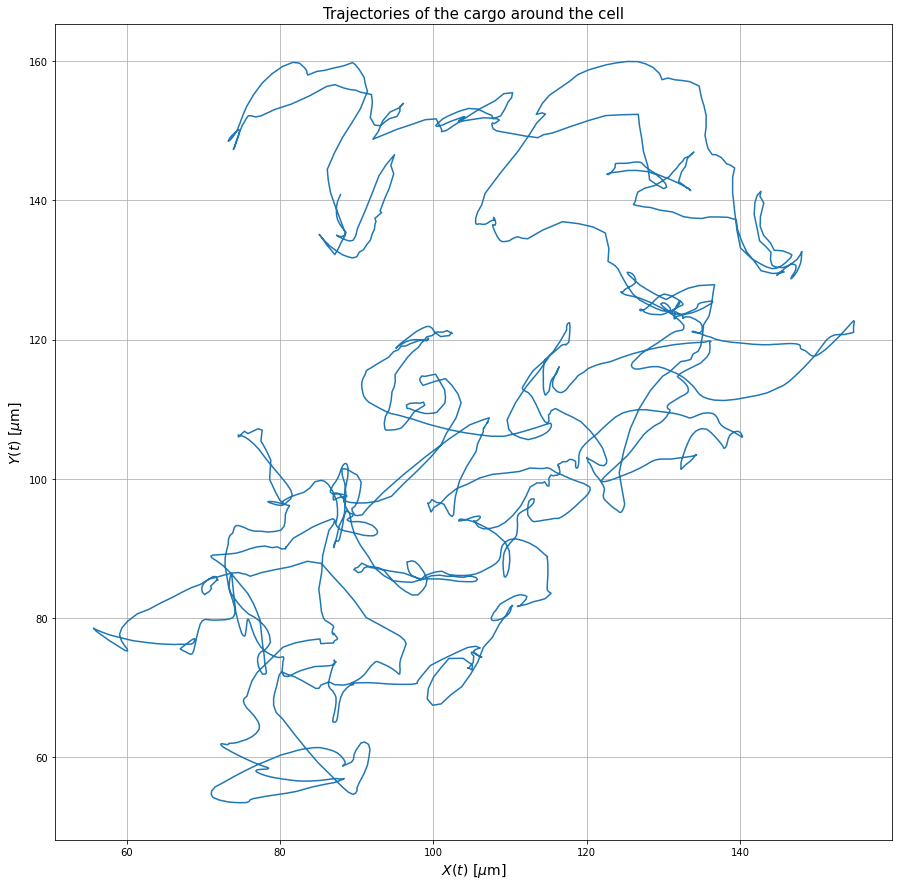

In [31]:
fig,ax = plt.subplots(figsize=(15, 15)) #for presentation plotted only first 10.000 steps
ax.set_ylabel('$Y(t)$ [$\mu$m]', fontsize=14)
ax.set_xlabel('$X(t)$ [$\mu$m]', fontsize=14)
ax.set_title('Trajectories of the cargo around the cell', fontsize=15)
ax.grid()
ax.plot(pk.X,pk.Y)

plt.show()

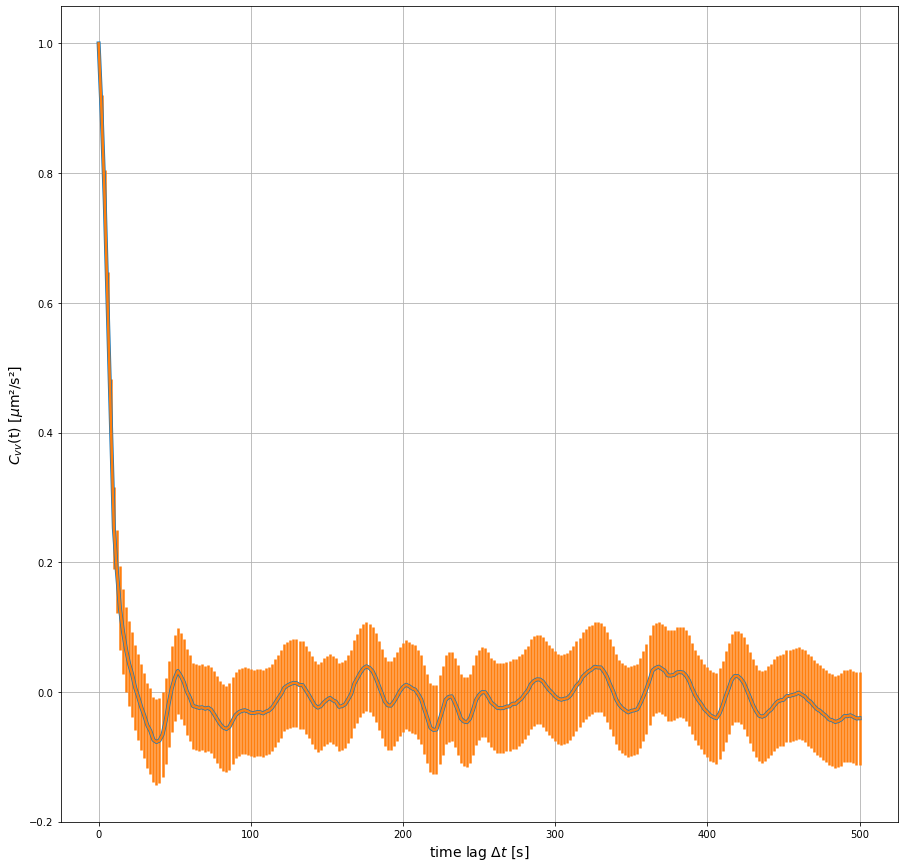

In [38]:
tL = dT*np.arange(0,nLags+1)

fig,ax = plt.subplots(figsize=(15, 15))
ax.set_xlabel('time lag $\Delta t$ [s]', fontsize=14)
ax.set_ylabel('$C_{vv}$(t) [$\mu$m²/s²]', fontsize=14)
ax.grid()

# plot data
ax.plot(tL,pk.corr_V,'-',linewidth=4.)
ax.errorbar(tL,pk.corr_V,yerr=2.*pk.u_corr_V,label='Traj 1',linewidth=2.5)
plt.show()

**Fitting approach [failed]**

From scipy documentation:

popt =: Optimal values for the parameters so that the sum of the squared residuals of f(xdata, *popt) - ydata is minimized.

pcov := the estimated covariance of popt.

In [39]:
popt, pcov = curve_fit(fit_VACF, tL, pk.corr_V,sigma=2.*pk.u_corr_V, maxfev=10000) 
print(popt, pcov)

[1. 1. 1. 1.] [[inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]]


/Users/giorgiamarcelli/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:755: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/Users/giorgiamarcelli/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


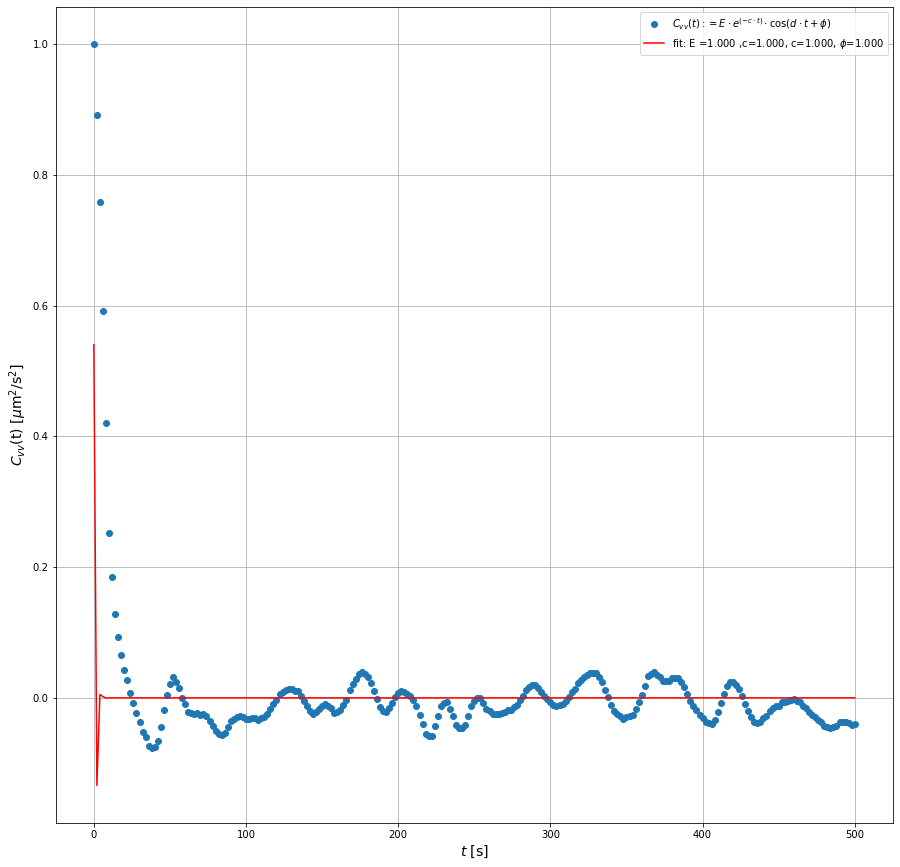

In [40]:
fig,ax = plt.subplots(figsize=(15, 15))
ax.set_ylabel('$C_{vv}$(t) [$\mu$m$^2$/s$^2$]', fontsize=14)
ax.set_xlabel('$t$ [s]', fontsize=14)
#ax.set_title('$C_{vv}(t)$', fontsize=15)
ax.grid()
ax.plot(tL, pk.corr_V, 'o', label="$C_{vv}(t):= E \cdot e^{(-c \cdot t)} \cdot \cos(d \cdot t+\phi) $")
ax.plot(tL, fit_VACF(tL, *popt), 'r-', label='fit: E =%5.3f ,c=%5.3f, c=%5.3f, $\phi$=%5.3f' % tuple(popt))
plt.legend()

plt.show()

In [41]:
E, c, d, phi= popt
print(E, c, d, phi)
tt = np.arange(1000)*0.5
sin_cvv = fit_VACF(tt, E, c, d, phi)

1.0 1.0 1.0 1.0


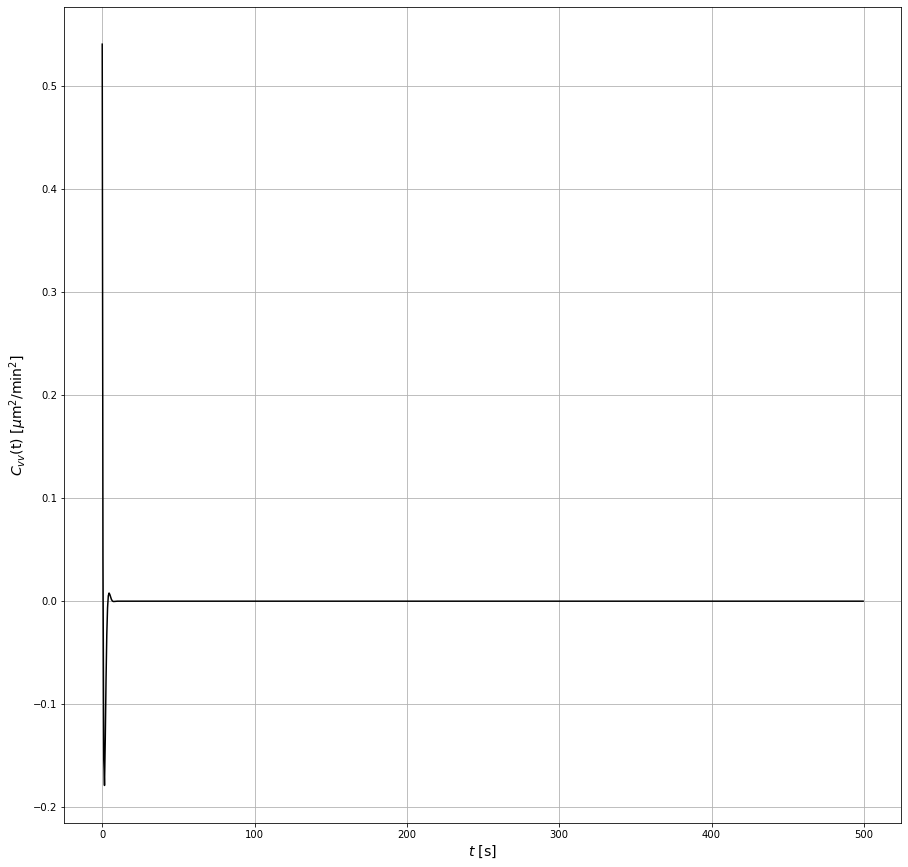

In [42]:
fig,ax = plt.subplots(figsize=(15, 15))
ax.set_ylabel('$C_{vv}$(t) [$\mu$m$^2$/min$^2$]', fontsize=14)
ax.set_xlabel('$t$ [s]', fontsize=14)
#ax.set_title('$C_{vv}(t)$', fontsize=15)
ax.grid()
ax.plot(tt, sin_cvv, 'k-')

#plt.savefig('cvv_sin.png')
plt.show()

**Computation of Memory Kernel**

In [43]:
G, K = Mem_kernel(sin_cvv, dT)
print(K[0:10])

[0.85286764 0.24860108 0.31162033 0.39061469 0.48963376 0.61375373
 0.76933754 0.96436116 1.20882238 1.51525343]


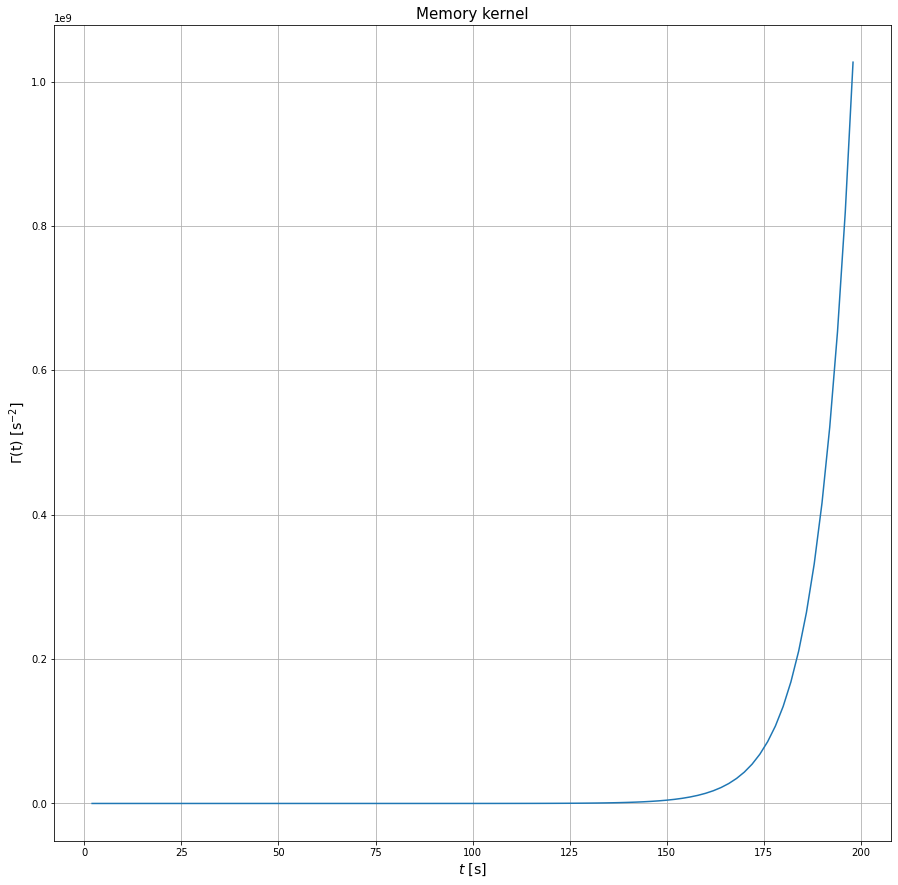

In [44]:
h = np.arange(len(K))*dT

fig,ax = plt.subplots(figsize=(15,15))
ax.set_ylabel('$\Gamma$(t) [s$^{-2}$]', fontsize=14)
ax.set_xlabel('$t$ [s]', fontsize=14)
ax.set_title('Memory kernel', fontsize=15)
ax.grid()

ax.plot(h[1:100], K[1:100])
#plt.savefig('sin_kernl.png')
plt.show()